TO:DO - add Markdowns - https://www.kaggle.com/richardnnamdi/customer-segmentation-ltv#Cohort-Based-Retention-Rate

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
#initiate visualization library for jupyter notebook 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pyoff.init_notebook_mode(connected=True)
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support as score




In [2]:
#visualizaition functions - courtesy Thiago Panini on kaggle
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

In [7]:
Olist_df = pd.read_csv('../datasets/Olist_final_clean.csv')

In [20]:
# load the data
customer = pd.read_csv('../datasets/olist/olist_customers_dataset.csv')
order = pd.read_csv('../datasets/olist/olist_orders_dataset.csv')
item = pd.read_csv('../datasets/olist/olist_order_items_dataset.csv')
payment = pd.read_csv('../datasets/olist/olist_order_payments_dataset.csv')

In [21]:
# creating master dataframe 
df1 = payment.merge(item, on='order_id')
df2 = df1.merge(order, on='order_id')
df = df2.merge(customer, on='customer_id')
print(df.shape)

(117601, 22)


In [22]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [23]:
# cleaning up name columns
df['customer_city'] = df['customer_city'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()
# engineering new/essential columns
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
# Changing the month attribute for correct ordenation
df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)
#creating year month column
df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [24]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

delivery_against_estimated  order_delivered_customer_date  \
Values                     2567.000000                    2567.000000   
Percentage                    2.182805                       2.182805   

            order_delivered_carrier_date  order_approved_at  payment_type  \
Values                       1245.000000          15.000000           0.0   
Percentage                      1.058664           0.012755           0.0   

            payment_installments  payment_value  order_item_id  product_id  \
Values                       0.0            0.0            0.0         0.0   
Percentage                   0.0            0.0            0.0         0.0   

            order_purchase_timestamp  seller_id  shipping_limit_date  price  \
Values                           0.0        0.0                  0.0    0.0   
Percentage                       0.0        0.0                  0.0    0.0   

            freight_value  customer_id  payment_sequential  order_status  \
Values                0.0          0.0                 0.0           0.0   
Percentage            0.0          0.0                 0.0           0.0   

            month_y  month_year  order_estimated_delivery_date  \
Values          0.0         0.0                            0.0   
Percentage      0.0         0.0                            0.0   

            customer_unique_id  customer_zip_code_prefix  customer_city  \
Values                     0.0                       0.0            0.0   
Percentage                 0.0                       0.0            0.0   

            customer_state  order_purchase_year  order_purchase_month  \
Values                 0.0                  0.0                   0.0   
Percentage             0.0                  0.0                   0.0   

            order_purchase_dayofweek  order_purchase_hour  order_purchase_day  \
Values                           0.0                  0.0                 0.0   
Percentage                       0.0                  0.0                 0.0   

            order_purchase_mon  order_id  
Values                     0.0       0.0  
Percentage                 0.0       0.0

In [25]:
# dropping missing values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [26]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  

In [29]:
# excluding incomplete 2012 data 
df = df.query("month_year != '2016-12' and month_year != '2016-10'")

# Recency

In [30]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

customer_unique_id  Recency
0  708ab75d2a007f0564aedd11139c7708      125
1  a8b9d3a27068454b1c98cc67d4e31e6f       64
2  6f70c0b2f7552832ba46eb57b1c5651e      260
3  87695ed086ebd36f20404c82d20fca87      266
4  4291db0da71914754618cd789aebcd56       28

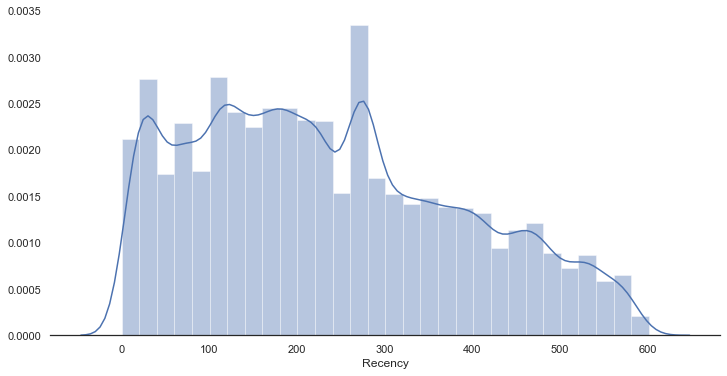

In [31]:
# plotting the distribution of the continous feature set
sns.set( color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

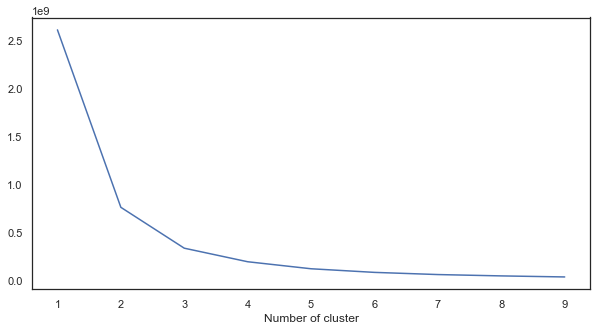

In [32]:
sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [33]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [34]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                               
0               14624.0  503.084587  42.798837  439.0  466.0  496.0  537.0   
1               18609.0  373.900425  34.084795  317.0  344.0  373.0  403.0   
2               27424.0  258.589155  31.146748  205.0  230.0  264.0  280.0   
3               29978.0  150.630396  30.874496   99.0  123.0  150.0  178.0   
4               24046.0   47.217791  27.082977    0.0   23.0   43.0   71.0   

                  max  
RecencyCluster         
0               601.0  
1               438.0  
2               316.0  
3               204.0  
4                98.0

# Frequency

In [36]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

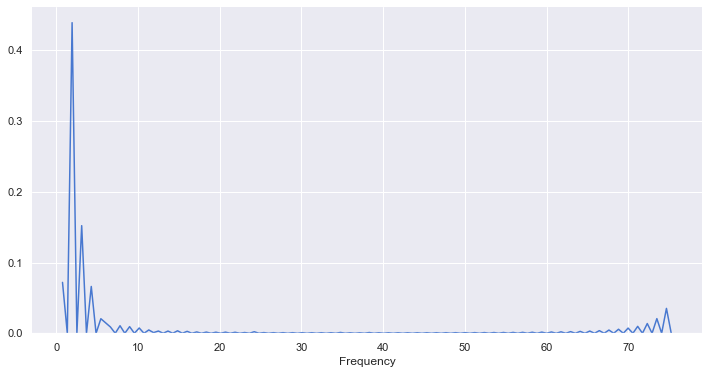

In [41]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [38]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

count       mean       std   min   25%   50%   75%   max
FrequencyCluster                                                            
0                 99875.0   1.207900  0.405807   1.0   1.0   1.0   1.0   2.0
1                 12870.0   4.039005  1.186489   3.0   3.0   4.0   5.0   7.0
2                  1464.0  10.831967  2.252463   8.0   9.0  11.0  12.0  16.0
3                   397.0  24.536524  6.099081  18.0  20.0  22.0  24.0  38.0
4                    75.0  75.000000  0.000000  75.0  75.0  75.0  75.0  75.0

# Monetary

In [39]:
#calculate revenue for each customer
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

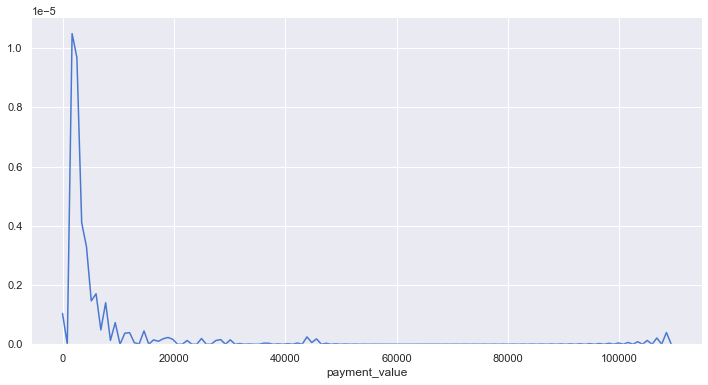

In [40]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

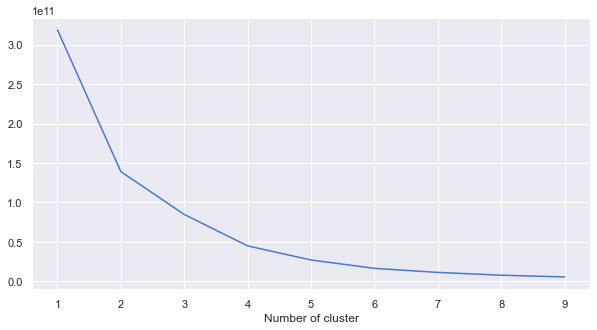

In [42]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [43]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

count           mean          std        min        25%  \
RevenueCluster                                                               
0               108108.0     192.070624   190.070330       9.59      67.50   
1                 5592.0    1870.895504   816.778862    1026.78    1247.52   
2                  743.0    7000.283419  2137.860492    4447.80    5289.12   
3                  184.0   20278.110435  5207.417793   14196.28   16313.60   
4                   46.0   43587.292174  2837.177072   36489.24   44048.00   
5                    8.0  109312.640000     0.000000  109312.64  109312.64   

                      50%        75%        max  
RevenueCluster                                   
0                  124.13     232.97    1026.48  
1                 1592.64    2211.12    4415.96  
2                 6317.22    7971.88   12490.88  
3                19174.38   25051.89   30186.00  
4                44048.00   45256.00   45256.00  
5               109312.64  109312.64  109312.64

In [44]:
#renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

Recency  Frequency      Monetary
OverallScore                                     
0             502.486153   1.207470    166.043273
1             384.014916   1.374942    198.962138
2             271.018133   1.468459    221.534546
3             167.438145   1.585506    255.314096
4              69.003531   1.702820    310.602300
5             103.659494   6.017214   1235.705094
6              90.805680   6.739910   3053.829791
7             114.172260  11.863535   6191.532438
8             156.974843  12.257862  24128.473333
10             96.454545  22.181818  35259.341818

In [45]:
#assigning value labels to our segments
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

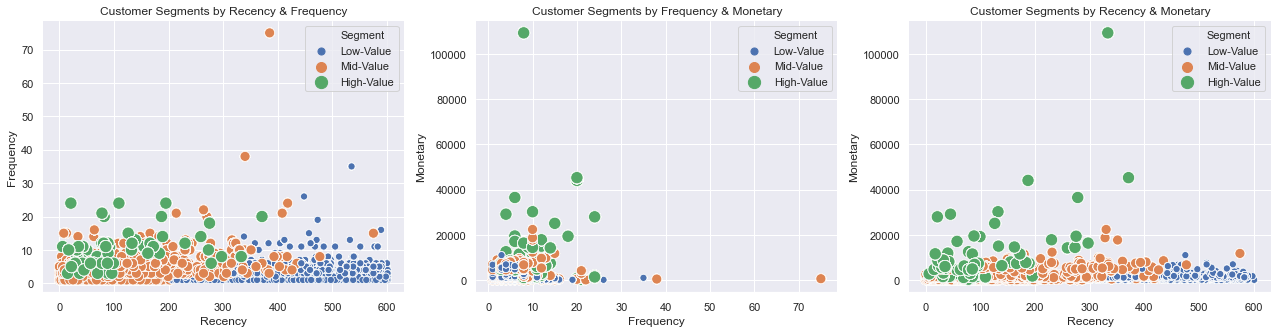

In [47]:
# plotting the distribution of the continous feature set
sns.set(color_codes=True)
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

In [48]:
# visualize the customer segments via plotly
fig = px.scatter_3d(df_user, x='Recency', y='Monetary', z='Frequency', color='Segment', opacity=0.5, size_max=5)
fig.show()

In [49]:
# the mean value for each cluster
cluster_avg = df_user.groupby('Segment').mean()
cluster_avg.drop(['RecencyCluster','FrequencyCluster', 'RevenueCluster'], axis = 1)

Recency  Frequency      Monetary  OverallScore
Segment                                                      
High-Value  123.443077  12.658462  12546.851231      7.447692
Low-Value   292.965503   1.450648    220.248271      1.841531
Mid-Value    74.375693   2.477273    552.314711      4.217372

In [50]:
Olist = pd.read_csv('../datasets/Olist_final_clean.csv')
Olist.head()

order_id order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214             1   
1  130898c0987d1801452a8ed92a670612             1   
2  532ed5e14e24ae1f0d735b91524b98b9             1   
3  6f8c31653edb8c83e1a739408b5ff750             1   
4  7d19f4ef4d04461989632411b7e588b9             1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

   shipping_limit_date price freight_value payment_sequential payment_type  \
0  2017-09-19 09:45:35  58.9         13.29                  1  Credit Card   
1  2017-07-05 02:44:11  55.9         17.96                  1       Boleto   
2  2018-05-23 10:56:25  64.9         18.33                  1  Credit Card   
3  2017-08-07 18:55:08  58.9         16.17                  1  Credit Card   
4  2017-08-16 22:05:11  58.9         13.29                  1  Credit Card   

  payment_installments payment_value product_category_name  \
0                    2         72.19            Cool Stuff   
1                    1         73.86            Cool Stuff   
2                    2         83.23            Cool Stuff   
3                    3         75.07            Cool Stuff   
4                    4         72.19            Cool Stuff   

  product_name_lenght product_description_lenght  product_photos_qty  \
0                  58                        598                 4.0   
1                  58                        598                 4.0   
2                  58                        598                 4.0   
3                  58                        598                 4.0   
4                  58                        598                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1             650.0               28.0                9.0              14.0   
2             650.0               28.0                9.0              14.0   
3             650.0               28.0                9.0              14.0   
4             650.0               28.0                9.0              14.0   

  seller_zip_code_prefix    seller_city seller_state  \
0                  27277  Volta Redonda           SP   
1                  27277  Volta Redonda           SP   
2                  27277  Volta Redonda           SP   
3                  27277  Volta Redonda           SP   
4                  27277  Volta Redonda           SP   

                          review_id  review_score review_comment_title  \
0  97ca439bc427b48bc1cd7177abe71365             5                  NaN   
1  b11cba360bbe71410c291b764753d37f             5                  NaN   
2  af01c4017c5ab46df6cc810e069e654a             4      super recomendo   
3  8304ff37d8b16b57086fa283fe0c44f8             5                  NaN   
4  426f43a82185969503fb3c86241a9535             5                  NaN   

                              review_comment_message review_creation_date  \
0     Perfeito, produto entregue antes do combinado.  2017-09-21 00:00:00   
1  lannister como sempre, entregou certinho e den...  2017-07-14 00:00:00   
2                              carrinho muito bonito  2018-06-05 00:00:00   
3                                                NaN  2017-08-10 00:00:00   
4                                                NaN  2017-08-25 00:00:00   

  review_answer_timestamp                       customer_id order_status  \
0     2017-09-22 10:57:03  3ce436f183e68e07877b285a838db11a    delivered   
1     2017-07-17 12:50:07  e6eecc5a77de221464d1c4eaff0a9b64    delivered   
2     2018-06-06 21:41:12  4ef55bf80f711b372af

In [51]:
# Merge RFM to original dataframe
olist_class = Olist.merge(df_user, how='inner', on='customer_unique_id').copy()


In [52]:
olist_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206411 entries, 0 to 206410
Data columns (total 68 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       206411 non-null  object 
 1   order_item_id                  206411 non-null  object 
 2   product_id                     206411 non-null  object 
 3   seller_id                      206411 non-null  object 
 4   shipping_limit_date            206411 non-null  object 
 5   price                          206411 non-null  object 
 6   freight_value                  206411 non-null  object 
 7   payment_sequential             206411 non-null  object 
 8   payment_type                   206411 non-null  object 
 9   payment_installments           206411 non-null  object 
 10  payment_value                  206411 non-null  object 
 11  product_category_name          203477 non-null  object 
 12  product_name_lenght           

In [61]:
#checkpoint save CSV
olist_class.to_csv('../datasets/Olist_final_with_segments.csv', index = False)

# Understanding the customer segments (EDA to be done)

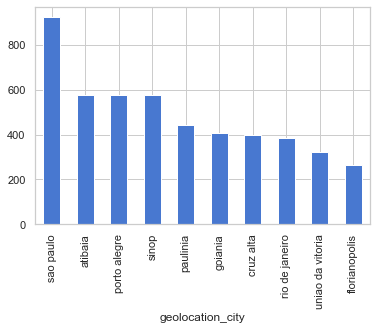

In [62]:
olist_class.groupby('Segment')['geolocation_city'].value_counts()['High-Value'][:10].plot(kind = 'bar');

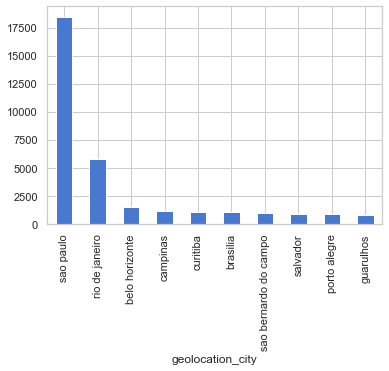

In [63]:
olist_class.groupby('Segment')['geolocation_city'].value_counts()['Mid-Value'][:10].plot(kind = 'bar');

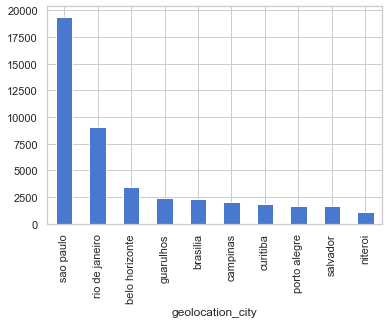

In [64]:
olist_class.groupby('Segment')['geolocation_city'].value_counts()['Low-Value'][:10].plot(kind = 'bar');

# Modelling

In [53]:
# Predictor Columns
all_columns = [
    'customer_state'
    , 'order_status'
    , 'price'
    , 'freight_value'
    , 'product_category_name'
    , 'product_photos_qty'
    , 'product_weight_g'
    , 'product_length_cm'
    , 'product_height_cm'
    , 'product_width_cm'
    , 'payment_sequential'
    , 'payment_type'
    , 'payment_installments'
    , 'payment_value'
    , 'review_score'
    , 'Segment'
]

In [54]:
# Copy only Predictor and Target Columns
dummy_seek = olist_class[all_columns].copy()
dummy_seek.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206411 entries, 0 to 206410
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_state         206411 non-null  object 
 1   order_status           206411 non-null  object 
 2   price                  206411 non-null  object 
 3   freight_value          206411 non-null  object 
 4   product_category_name  203477 non-null  object 
 5   product_photos_qty     203477 non-null  float64
 6   product_weight_g       206370 non-null  float64
 7   product_length_cm      206370 non-null  float64
 8   product_height_cm      206370 non-null  float64
 9   product_width_cm       206370 non-null  float64
 10  payment_sequential     206411 non-null  object 
 11  payment_type           206411 non-null  object 
 12  payment_installments   206411 non-null  object 
 13  payment_value          206411 non-null  object 
 14  review_score           206411 non-nu

In [55]:
# Create Dummy Variables for Customer State
dummy_seek = pd.get_dummies(dummy_seek, columns=['customer_state'], prefix=['customer_state'], drop_first=True)
dummy_seek.head()

order_status price freight_value product_category_name  product_photos_qty  \
0    delivered  58.9         13.29            Cool Stuff                 4.0   
1    delivered  55.9         17.96            Cool Stuff                 4.0   
2    delivered  64.9         18.33            Cool Stuff                 4.0   
3    delivered  58.9         16.17            Cool Stuff                 4.0   
4    delivered  58.9         13.29            Cool Stuff                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1             650.0               28.0                9.0              14.0   
2             650.0               28.0                9.0              14.0   
3             650.0               28.0                9.0              14.0   
4             650.0               28.0                9.0              14.0   

  payment_sequential payment_type payment_installments payment_value  \
0                  1  Credit Card                    2         72.19   
1                  1       Boleto                    1         73.86   
2                  1  Credit Card                    2         83.23   
3                  1  Credit Card                    3         75.07   
4                  1  Credit Card                    4         72.19   

   review_score    Segment  customer_state_AL  customer_state_AM  \
0             5  Low-Value                  0                  0   
1             5  Low-Value                  0                  0   
2             4  Low-Value                  0                  0   
3             5  Low-Value                  0                  0   
4             5  Low-Value                  0                  0   

   customer_state_AP  customer_state_BA  customer_state_CE  customer_state_DF  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_ES  customer_state_GO  customer_state_MA  customer_state_MG  \
0                  0                  0                  0                  0   
1                  0                  1                  0                  0   
2                  0                  0                  0                  1   
3                  0                  0                  0                  0   
4                  0                  0                  0                  1   

   customer_state_MS  customer_state_MT  customer_state_PA  customer_state_PB  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PE  customer_state_PI  customer_state_PR  customer_state_RJ  \
0                  0                  0                  0                  1   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  1                  0   
4                  0                  0                  0                  0   

   customer_state_RN  customer_state_RO  customer_state_RR  customer_state_RS  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2            

In [56]:
# Create Dummy Variables for Order Status
dummy_seek = pd.get_dummies(dummy_seek, columns=['order_status'], prefix=['order_status'], drop_first=True)
dummy_seek.head()

price freight_value product_category_name  product_photos_qty  \
0  58.9         13.29            Cool Stuff                 4.0   
1  55.9         17.96            Cool Stuff                 4.0   
2  64.9         18.33            Cool Stuff                 4.0   
3  58.9         16.17            Cool Stuff                 4.0   
4  58.9         13.29            Cool Stuff                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1             650.0               28.0                9.0              14.0   
2             650.0               28.0                9.0              14.0   
3             650.0               28.0                9.0              14.0   
4             650.0               28.0                9.0              14.0   

  payment_sequential payment_type payment_installments payment_value  \
0                  1  Credit Card                    2         72.19   
1                  1       Boleto                    1         73.86   
2                  1  Credit Card                    2         83.23   
3                  1  Credit Card                    3         75.07   
4                  1  Credit Card                    4         72.19   

   review_score    Segment  customer_state_AL  customer_state_AM  \
0             5  Low-Value                  0                  0   
1             5  Low-Value                  0                  0   
2             4  Low-Value                  0                  0   
3             5  Low-Value                  0                  0   
4             5  Low-Value                  0                  0   

   customer_state_AP  customer_state_BA  customer_state_CE  customer_state_DF  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_ES  customer_state_GO  customer_state_MA  customer_state_MG  \
0                  0                  0                  0                  0   
1                  0                  1                  0                  0   
2                  0                  0                  0                  1   
3                  0                  0                  0                  0   
4                  0                  0                  0                  1   

   customer_state_MS  customer_state_MT  customer_state_PA  customer_state_PB  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PE  customer_state_PI  customer_state_PR  customer_state_RJ  \
0                  0                  0                  0                  1   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  1                  0   
4                  0                  0                  0                  0   

   customer_state_RN  customer_state_RO  customer_state_RR  customer_state_RS  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3         

In [57]:
# Create Dummy Variables for Product Category
dummy_seek = pd.get_dummies(dummy_seek, columns=['product_category_name'], prefix=['product_category_name'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_type payment_installments payment_value  review_score    Segment  \
0  Credit Card                    2         72.19             5  Low-Value   
1       Boleto                    1         73.86             5  Low-Value   
2  Credit Card                    2         83.23             4  Low-Value   
3  Credit Card                    3         75.07             5  Low-Value   
4  Credit Card                    4         72.19             5  Low-Value   

   customer_state_AL  customer_state_AM  customer_state_AP  customer_state_BA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_CE  customer_state_DF  customer_state_ES  customer_state_GO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MA  customer_state_MG  customer_state_MS  customer_state_MT  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  0                  0                  0   
4                  0                  1                  0                  0   

   customer_state_PA  customer_state_PB  customer_state_PE  customer_state_PI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PR  customer_state_RJ  customer_state_RN  customer_state_RO  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  1                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_RR  customer_state_RS  customer_state_SC  customer_state_SE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  

In [58]:
# Create Dummy Variables for Payment Type
dummy_seek = pd.get_dummies(dummy_seek, columns=['payment_type'], prefix=['payment_type'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_installments payment_value  review_score    Segment  \
0                    2         72.19             5  Low-Value   
1                    1         73.86             5  Low-Value   
2                    2         83.23             4  Low-Value   
3                    3         75.07             5  Low-Value   
4                    4         72.19             5  Low-Value   

   customer_state_AL  customer_state_AM  customer_state_AP  customer_state_BA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_CE  customer_state_DF  customer_state_ES  customer_state_GO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MA  customer_state_MG  customer_state_MS  customer_state_MT  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  0                  0                  0   
4                  0                  1                  0                  0   

   customer_state_PA  customer_state_PB  customer_state_PE  customer_state_PI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PR  customer_state_RJ  customer_state_RN  customer_state_RO  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  1                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_RR  customer_state_RS  customer_state_SC  customer_state_SE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0               

In [59]:
# Create Dummy Variables for Review score
dummy_seek = pd.get_dummies(dummy_seek, columns=['review_score'], prefix=['review_score'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_installments payment_value    Segment  customer_state_AL  \
0                    2         72.19  Low-Value                  0   
1                    1         73.86  Low-Value                  0   
2                    2         83.23  Low-Value                  0   
3                    3         75.07  Low-Value                  0   
4                    4         72.19  Low-Value                  0   

   customer_state_AM  customer_state_AP  customer_state_BA  customer_state_CE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_DF  customer_state_ES  customer_state_GO  customer_state_MA  \
0                  0                  0                  0                  0   
1                  0                  0                  1                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MG  customer_state_MS  customer_state_MT  customer_state_PA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  1                  0                  0                  0   
3                  0                  0                  0                  0   
4                  1                  0                  0                  0   

   customer_state_PB  customer_state_PE  customer_state_PI  customer_state_PR  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  1   
4                  0                  0                  0                  0   

   customer_state_RJ  customer_state_RN  customer_state_RO  customer_state_RR  \
0                  1                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_RS  customer_state_SC  customer_state_SE  customer_state_SP  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0    

In [62]:
# Check Columns
dummy_seek.columns

Index(['price', 'freight_value', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_installments', 'payment_value',
       ...
       'product_category_name_Telephony', 'product_category_name_Toys',
       'product_category_name_Watches Gifts', 'payment_type_Credit Card',
       'payment_type_Debit Card', 'payment_type_Voucher', 'review_score_2',
       'review_score_3', 'review_score_4', 'review_score_5'],
      dtype='object', length=120)

In [63]:
# Get Highcolumn using all other columns
target_column = 'Segment'
predictor_columns = [s for s in dummy_seek.columns.tolist() if s != target_column]

In [64]:
dummy_seek.shape

(206411, 120)

In [65]:
dummy_seek.dropna(inplace = True)

In [66]:
dummy_seek.shape

(203476, 120)

# Modelling

In [67]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(dummy_seek[predictor_columns], dummy_seek[target_column], random_state = 42)

In [68]:
X_train.shape

(152607, 119)

In [69]:
y_train.shape

(152607,)

In [70]:
X_test.shape

(50869, 119)

In [71]:
y_test.shape

(50869,)

In [72]:
# Standardize Train and Test
scaling = StandardScaler().fit(X_train)

X_trainstd = scaling.transform(X_train)
X_teststd = scaling.transform(X_test)

In [73]:
logreg = LogisticRegression()
logreg.fit(X_trainstd, y_train)

LogisticRegression()

In [74]:
# decent baseline score of 71%
logreg.score(X_teststd, y_test)

0.7103147299927264

              precision    recall  f1-score   support

  High-Value       0.76      0.55      0.64      2071
   Low-Value       0.72      0.90      0.80     30627
   Mid-Value       0.67      0.42      0.52     18171

    accuracy                           0.71     50869
   macro avg       0.72      0.62      0.65     50869
weighted avg       0.70      0.71      0.69     50869



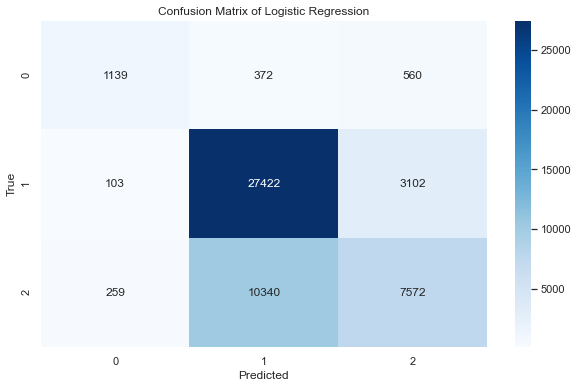

In [75]:
y_pred = logreg.predict(X_teststd)
    
print(classification_report(y_test, y_pred))

# confusion matrix - heat map plot
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

fig.savefig('logisticregression.png', bbox_inches='tight');

In [86]:
random_grid = {
    'n_estimators': [20, 40, 60, 80, 100]
    , 'max_features': ['auto', 'sqrt']
    , 'max_depth': [10, 55, 100, None]
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 25 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 55, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [20, 40, 60, 80, 100]},
                   random_state=42, verbose=2)

In [87]:
rf_random.best_estimator_, rf_random.best_score_

(RandomForestClassifier(max_depth=55, max_features='sqrt'), 0.9253900555892385)

In [88]:
# Fit Random Forest Classfier

clf = RandomForestClassifier(n_estimators=82, max_depth=55, max_features='sqrt', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=55, max_features='sqrt', n_estimators=82,
                       random_state=42)

In [89]:
# RF with a score of 93% 
score = clf.score(X_test, y_test)
score

0.9335941339519157

              precision    recall  f1-score   support

  High-Value       1.00      1.00      1.00      2071
   Low-Value       0.91      0.99      0.95     30627
   Mid-Value       0.97      0.84      0.90     18171

    accuracy                           0.93     50869
   macro avg       0.96      0.94      0.95     50869
weighted avg       0.94      0.93      0.93     50869



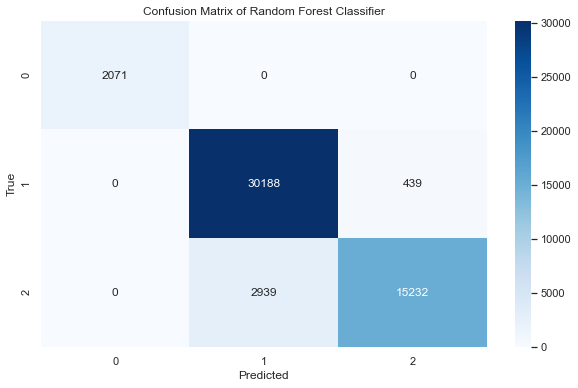

In [90]:
y_pred = clf.predict(X_test)
    
print(classification_report(y_test, y_pred))

# confusion matrix - heat map plot
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix of Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

fig.savefig('randomforest.png', bbox_inches='tight');

In [91]:
clf.feature_importances_

array([1.07338583e-01, 1.34247753e-01, 3.39323760e-02, 8.01290396e-02,
       6.18408212e-02, 6.69376936e-02, 6.12505831e-02, 1.84722242e-02,
       3.45993285e-02, 1.52769767e-01, 5.45064057e-04, 2.98244062e-04,
       1.45827694e-04, 4.27540412e-03, 1.87091809e-03, 2.47493769e-03,
       2.26596970e-03, 3.88232447e-03, 1.11046473e-03, 6.80889936e-03,
       1.07234878e-03, 3.19397751e-03, 1.25531745e-03, 9.53071833e-04,
       2.55530898e-03, 7.56489011e-04, 5.41165772e-03, 7.80862103e-03,
       7.38664107e-04, 5.77232699e-04, 6.76732220e-05, 6.36333335e-03,
       4.15985675e-03, 5.72464460e-04, 1.21017106e-02, 6.05341991e-04,
       2.34417569e-04, 1.80117990e-05, 5.52599883e-05, 1.11265047e-04,
       5.15851316e-04, 3.03122793e-04, 1.96424476e-04, 4.78539789e-04,
       4.36711863e-03, 3.36798151e-03, 7.34948190e-03, 6.65746530e-04,
       1.55150196e-04, 3.56727861e-04, 4.42194759e-06, 3.21911865e-04,
       2.22881455e-04, 3.62337608e-04, 6.57957744e-03, 1.12554584e-03,
      

In [92]:
# Get feature importance from model and map them with feature names from tfidf     
feature_importances = pd.DataFrame(
    clf.feature_importances_
    , index = X_train.columns
    , columns=['importance']
).sort_values(by='importance', ascending=False)

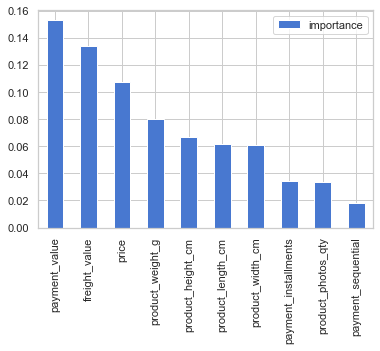

In [93]:
feature_importances.head(10).plot(kind = 'bar')

# Clearly, payment value is the biggest predictor of customer segments. Which is intuitive but not very insightful. In the next sheet, I will explore a different method to understand customers from a non-monetary perspective.